# binary Study with ***information gain && Fast Correlation Based Filter (FCBF)***

### In pursuit of a well-balanced dataset, a stratified selection approach was employed, randomly extracting 20\% of samples from each class encompassed within the CICIDS2017 dataset.

##### The distinct categories of malicious attacks, comprising **Infiltration, WebAttack, BruteForce, Bot, PortScan, and DoS**, were effectively amalgamated and designated under the unified label of WebAttack. This consolidation facilitated the formation of two distinct cohorts: Normaltraffic and WebAttack, resulting in a database configuration with 454,619 instances of Normaltraffic and 111,526 instances of WebAttack.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

### Read the sampled CICIDS2017 dataset

In [3]:
df = pd.read_csv('./data/CICIDS2017_20Percent.csv')

In [4]:
df.Label.value_counts()

Normaltraffic            454619
DoSHulk                   46216
PortScan                  31786
DDoS                      25596
DoSGoldenEye               2060
FTPPatator                 1588
SSHPatator                 1179
DoSslowloris               1160
DoSSlowhttptest            1101
Bot                         393
WebAttackBruteForce         301
WebAttackXSS                132
Infiltration                  7
WebAttackSqlInjection         4
Heartbleed                    3
Name: Label, dtype: int64

In [5]:
# Define the mapping of old class names to new class name (WebAttack)
class_mapping = {
    'DoSHulk': 'WebAttack',
    'PortScan': 'WebAttack',
    'DDoS': 'WebAttack',
    'DoSGoldenEye': 'WebAttack',
    'FTPPatator': 'WebAttack',
    'SSHPatator': 'WebAttack',
    'DoSslowloris': 'WebAttack',
    'DoSSlowhttptest': 'WebAttack',
    'Bot': 'WebAttack',
    'WebAttackBruteForce': 'WebAttack',
    'WebAttackXSS': 'WebAttack',
    'Infiltration': 'WebAttack',
    'WebAttackSqlInjection': 'WebAttack',
    'Heartbleed': 'WebAttack'
}

# Replace the old class names with the new class name 'WebAttack'
df['Label'] = df['Label'].replace(class_mapping)

In [6]:
df.Label.value_counts()

Normaltraffic    454619
WebAttack        111526
Name: Label, dtype: int64

In [7]:
# Min-max normalization
numeric_features = df.dtypes[df.dtypes != 'object'].index
df[numeric_features] = df[numeric_features].apply(
    lambda x: (x - x.min()) / (x.max()-x.min()))
# Fill empty values by 0
df = df.fillna(0)

In [8]:
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])
X = df.drop(['Label'],axis=1).values 
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [9]:
X_train.shape

(452916, 77)

In [10]:
pd.Series(y_train).value_counts()

0    363695
1     89221
dtype: int64

## Feature engineering

### Feature selection by information gain

In [11]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X_train, y_train)

In [12]:
features = df.dtypes[df.dtypes != 'object'].index
features

Index(['DestinationPort', 'Flow_Duration', 'Total_Fwd_Packets',
       'Total_Backward_Packets', 'Total_Length_of_Fwd_Packets',
       'Total_Length_of_Bwd_Packets', 'Fwd_Packet_Length_Max',
       'Fwd_Packet_Length_Min', 'Fwd_Packet_Length_Mean',
       'Fwd_Packet_Length_Std', 'Bwd_Packet_Length_Max',
       'Bwd_Packet_Length_Min', 'Bwd_Packet_Length_Mean',
       'Bwd_Packet_Length_Std', 'Flow_Bytes_s', 'Flow_Packets_s',
       'Flow_IAT_Mean', 'Flow_IAT_Std', 'Flow_IAT_Max', 'Flow_IAT_Min',
       'Fwd_IAT_Total', 'Fwd_IAT_Mean', 'Fwd_IAT_Std', 'Fwd_IAT_Max',
       'Fwd_IAT_Min', 'Bwd_IAT_Total', 'Bwd_IAT_Mean', 'Bwd_IAT_Std',
       'Bwd_IAT_Max', 'Bwd_IAT_Min', 'Fwd_PSH_Flags', 'Bwd_PSH_Flags',
       'Fwd_URG_Flags', 'Bwd_URG_Flags', 'Fwd_Header_Length1',
       'Bwd_Header_Length', 'Fwd_Packets_s', 'Bwd_Packets_s',
       'Min_Packet_Length', 'Max_Packet_Length', 'Packet_Length_Mean',
       'Packet_Length_Std', 'Packet_Length_Variance', 'FIN_Flag_Count',
       'SYN_Flag_Co

In [13]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [14]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break    

In [15]:
X_fs = df[fs].values

In [16]:
X_fs.shape

(566145, 45)

### Feature selection by Fast Correlation Based Filter (FCBF)

The module is imported from the GitHub repo: https://github.com/SantiagoEG/FCBF_module

In [17]:
from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
fcbf = FCBFK(k = 20)
#fcbf.fit(X_fs, y)

In [18]:
X_fss = fcbf.fit_transform(X_fs,y)

In [19]:
X_fss.shape

(566145, 20)

### Re-split train & test sets after feature selection

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_fss,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [21]:
X_train.shape

(452916, 20)

In [22]:
pd.Series(y_train).value_counts()

0    363695
1     89221
dtype: int64

**Corresponding Attack Types:**  
0 Bot   
3 Infiltration          
6 WebAttack    
1 BruteForce                 
5 PortScan        
2 DoS      
4 Normaltraffic  

## Machine learning model training

### Training four base learners: decision tree, random forest, extra trees, XGBoost

#### Apply XGBoostFT

Accuracy of XGBoost: 0.9928728505948122
Precision of XGBoost: 0.9929020436100866
Recall of XGBoost: 0.9928728505948122
F1-score of XGBoost: 0.992883581261448
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     90924
           1       0.98      0.99      0.98     22305

    accuracy                           0.99    113229
   macro avg       0.99      0.99      0.99    113229
weighted avg       0.99      0.99      0.99    113229



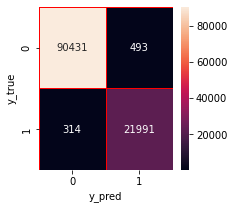

In [23]:
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(3,3))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [24]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

#### Apply RF

Accuracy of RF: 0.9965998110024817
Precision of RF: 0.9966161541411164
Recall of RF: 0.9965998110024817
F1-score of RF: 0.9966045889476979
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     90924
           1       0.99      1.00      0.99     22305

    accuracy                           1.00    113229
   macro avg       0.99      1.00      0.99    113229
weighted avg       1.00      1.00      1.00    113229



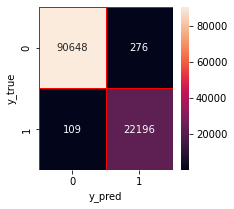

In [26]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train) 
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(3,3))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [27]:
rf_train=rf.predict(X_train)
rf_test=rf.predict(X_test)

#### Apply DT

Accuracy of DT: 0.9965026627454098
Precision of DT: 0.9965211324659297
Recall of DT: 0.9965026627454098
F1-score of DT: 0.9965079576016965
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     90924
           1       0.99      1.00      0.99     22305

    accuracy                           1.00    113229
   macro avg       0.99      1.00      0.99    113229
weighted avg       1.00      1.00      1.00    113229



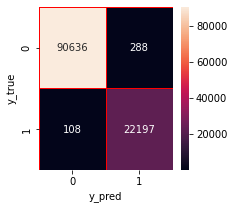

In [25]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train) 
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(3,3))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [28]:
dt_train=dt.predict(X_train)
dt_test=dt.predict(X_test)

#### Apply ET

Accuracy of ET: 0.9966174743219494
Precision of ET: 0.996633493662009
Recall of ET: 0.9966174743219494
F1-score of ET: 0.9966221708183077
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     90924
           1       0.99      1.00      0.99     22305

    accuracy                           1.00    113229
   macro avg       0.99      1.00      0.99    113229
weighted avg       1.00      1.00      1.00    113229



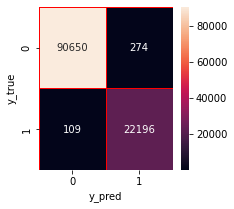

In [40]:
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train,y_train) 
et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(3,3))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [30]:
et_train=et.predict(X_train)
et_test=et.predict(X_test)

### Apply Stacking
The ensemble model that combines the four ML models (DT, RF, ET, XGBoost)

In [31]:
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0


In [34]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [35]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

Accuracy of Stacking: 0.9965026627454098
Precision of Stacking: 0.9965211324659297
Recall of Stacking: 0.9965026627454098
F1-score of Stacking: 0.9965079576016965
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     90924
           1       0.99      1.00      0.99     22305

    accuracy                           1.00    113229
   macro avg       0.99      1.00      0.99    113229
weighted avg       1.00      1.00      1.00    113229



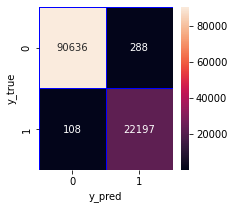

In [37]:
stk = xgb.XGBClassifier().fit(x_train, y_train)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(3,3))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="blue",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## PLOT IMPORTANCE FEATURES AFTER (IG & FCBE)

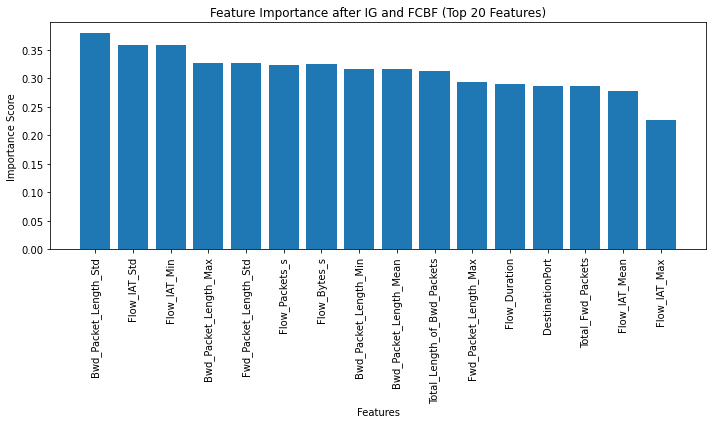

In [39]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from FCBF_module import FCBFK

# Calculate the feature importance scores using Information Gain (IG)
importances_ig = mutual_info_classif(X_train, y_train)

# Create a list of features
features = df.dtypes[df.dtypes != 'object'].index

# Calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances_ig), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

# Select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances_ig/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2 >= 0.9:
        break

# Apply Fast Correlation-Based Filter (FCBF)
#fcbf = FCBFK(k=20)
#X_fss = fcbf.fit_transform(X_train, y_train)

# Get the top 20 features
top_features = fs[:20]

# Get the importance scores of the top 20 features
top_importances = [importances_ig[features.get_loc(feature)] for feature in top_features]

# Plot the feature importance after IG and FCBF for the top 20 features
plt.figure(figsize=(10, 6))
plt.bar(range(len(top_importances)), top_importances)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importance after IG and FCBF (Top 20 Features)')
plt.xticks(range(len(top_importances)), top_features, rotation='vertical')
plt.tight_layout()
plt.show()